# Interpretable ML - COVID19
> Demo for Interpretable ML
- toc:true
- branch: master
- badges: true
- comments: true
- author: Han Wu
- categories: [jupyter]

## 0. Load Data

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
np.set_printoptions(suppress=True)

In [3]:
covid = pd.read_csv("dataset/covid.csv")

In [4]:
print("AVG age for severity 0:", np.mean(covid[covid.Severity03 == 0].Age.to_numpy()))
print("AVG age for severity 1:", np.mean(covid[covid.Severity03 == 1].Age.to_numpy()))
print("AVG age for severity 2:", np.mean(covid[covid.Severity03 == 2].Age.to_numpy()))
print("AVG age for severity 3:", np.mean(covid[covid.Severity03 == 3].Age.to_numpy()))

AVG age for severity 0: 36.833333333333336
AVG age for severity 1: 47.45283018867924
AVG age for severity 2: 54.3125
AVG age for severity 3: 69.4


## 1. Data Wash

Remove NULL Features

In [5]:
remove_columns = ['MedNum', 'LVEF', 'SO2', 'PO2', 'YHZS', 'RML', 'RUL', 'RLL', 'LUL', 'LLL']

In [6]:
covid = covid.drop(remove_columns, axis=1)

Remove Partially NULL Features

In [7]:
remove_columns = ['Onset2Admi', 'Onset2CT1', 'Onset2CTPositive1', 'Onset2CTPeak']

In [8]:
covid = covid.drop(remove_columns, axis=1)

Remove " " Features

In [9]:
covid = covid[covid.Weight != " "]

In [10]:
covid = covid[covid.cTnI != " "]

String to Float

In [11]:
covid['Weight'] = covid['Weight'].astype(np.float64)
covid['Height'] = covid['Height'].astype(np.float64)
covid['cTnITimes'] = covid['cTnITimes'].astype(np.float64)
covid['cTnI'] = covid['cTnI'].astype(np.float64)
covid['NTproBNP'] = covid['NTproBNP'].astype(np.float64)
covid['Cr'] = covid['Cr'].astype(np.float64)

## 2. Train Test Split

### Add New Features

In [12]:
covid['NSympton'] = covid['Fever'] + covid['Cough'] + covid['Phlegm']\
+ covid['Hemoptysis'] + covid['SoreThroat'] + covid['Catarrh']\
+ covid['Headache'] + covid['ChestPain'] + covid['Fatigue']\
+ covid['SoreMuscle']+covid['Stomachache'] + covid['Diarrhea']\
+ covid['PoorAppetite'] + covid['NauseaNVomit']

In [13]:
covid['NDisease'] = covid['Hypertention'] + covid['Hyperlipedia'] + covid['DM']\
+ covid['Lung'] + covid['CAD'] + covid['Arrythmia'] + covid['Cancer']

In [14]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [15]:
y = covid.Severity01.to_numpy()

In [16]:
# Use Both
# covid = covid.drop(["Severity01", "Severity03"], axis=1)

In [17]:
# Use AIVolume
# covid = covid.drop(["Severity01", "Severity03", "CTScore"], axis=1)

In [18]:
# Use CTScore
# covid = covid.drop(["Severity01", "Severity03", "AIVolumeP"], axis=1)

In [19]:
# Use None
covid = covid.drop(["Severity01", "Severity03", "CTScore", "AIVolumeP"], axis=1)

In [20]:
covid = covid.drop(["No"], axis=1)

In [21]:
X = covid
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 1)

In [22]:
X_train.shape, X_test.shape

((77, 57), (9, 57))

In [23]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Height', 'Weight', 'BMI', 'Temp', 'cTnITimes',
       'cTnI', 'cTnICKMBOrdinal1', 'cTnICKMBOrdinal2', 'AST', 'LDH', 'CK',
       'CKMB', 'HBDH', 'HiCKMB', 'NTproBNP', 'Cr', 'PCT1', 'WBC1', 'NEU1',
       'LYM1', 'N2L1', 'CRP1', 'ALB1', 'PCT2', 'WBC2', 'NEU2', 'LYM2', 'N2L2',
       'CRP2', 'ALB2', 'Sympton', 'Fever', 'Cough', 'Phlegm', 'Hemoptysis',
       'SoreThroat', 'Catarrh', 'Headache', 'ChestPain', 'Fatigue',
       'SoreMuscle', 'Stomachache', 'Diarrhea', 'PoorAppetite', 'NauseaNVomit',
       'Hypertention', 'Hyperlipedia', 'DM', 'Lung', 'CAD', 'Arrythmia',
       'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [24]:
y_test

array([0, 1, 0, 0, 1, 1, 0, 1, 0], dtype=int64)

## 3. Feature Selection

### 3.1 Basic Methods

#### 3.1.1 Drop constant and Quasi-constant features

Maybe those outliers are severe patients

In [25]:
from sklearn.feature_selection import VarianceThreshold

In [26]:
def drop_features(X_train, X_test, threshhold):
    sel = VarianceThreshold(threshold=threshhold)
    sel.fit(X_train)
    print("No. of constant features:",
        len([
            x for x in X_train.columns
            if x not in X_train.columns[sel.get_support()]
        ])
    )
    constant_features = [x for x in X_train.columns if x not in X_train.columns[sel.get_support()]]

    print(constant_features)
    X_train.drop(labels=constant_features, axis=1, inplace=True)
    X_test.drop(labels=constant_features, axis=1, inplace=True)

Drop constant and quasi-constant features

In [ ]:
drop_features(X_train, X_test, 0.01)

In [28]:
X_train.shape, X_test.shape

((77, 55), (9, 55))

#### 3.1.2 Drop Duplicated Features

Maybe some symptoms are correlated

In [29]:
covid_t = covid.T
print("No. of Duplicated Features:", covid_t.duplicated().sum())
print(covid_t[covid_t.duplicated()].index.values)

No. of Duplicated Features: 1
['Arrythmia']


Print out duplicated features

In [30]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    col_1 = X_train.columns[i]
    for col_2 in X_train.columns[i + 1 : ]:
        if X_train[col_1].equals(X_train[col_2]):
            print(col_1)
            print(col_2)         
            duplicated_feat.append(col_2)

CAD
Arrythmia


Drop duplicated features

In [31]:
# covid_unique = covid_t.drop_duplicates(keep='first').T

In [32]:
X_train.drop(labels=covid_t[covid_t.duplicated()].index.values, axis=1, inplace=True)
X_test.drop(labels=covid_t[covid_t.duplicated()].index.values, axis=1, inplace=True)

In [33]:
X_train.shape, X_test.shape

((77, 54), (9, 54))

### 3.2 Correlations

In [34]:
categorical_features = ['Sex', 'AgeG1', 
                        'Fever', 'Cough', 'Phlegm', 'Hemoptysis', 'SoreThroat', 'Catarrh', 'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', # 'Stomachache', 
                        'Diarrhea', 'PoorAppetite', 'NauseaNVomit', 
                        'Hypertention', 'Hyperlipedia', 'DM', 'Lung', #'CAD', 'Arrythmia', 
                        'Cancer']

In [35]:
numerical_features = ['Age', 'Height', 'Weight', 'BMI', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1', 'cTnICKMBOrdinal2', 'AST',
       'LDH', 'CK', 'CKMB', 'HBDH', 'HiCKMB', 'NTproBNP', 'Cr', 'PCT1', 'WBC1',
       'NEU1', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'WBC2', 'NEU2', 'LYM2', 'N2L2',
       'CRP2', 'ALB2']

In [36]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# numerical_vars = list(covid.select_dtypes(include=numerics).columns)
# data = covid[numerical_vars]

In [12]:
corrmat = X_train.corr()

<AxesSubplot:>

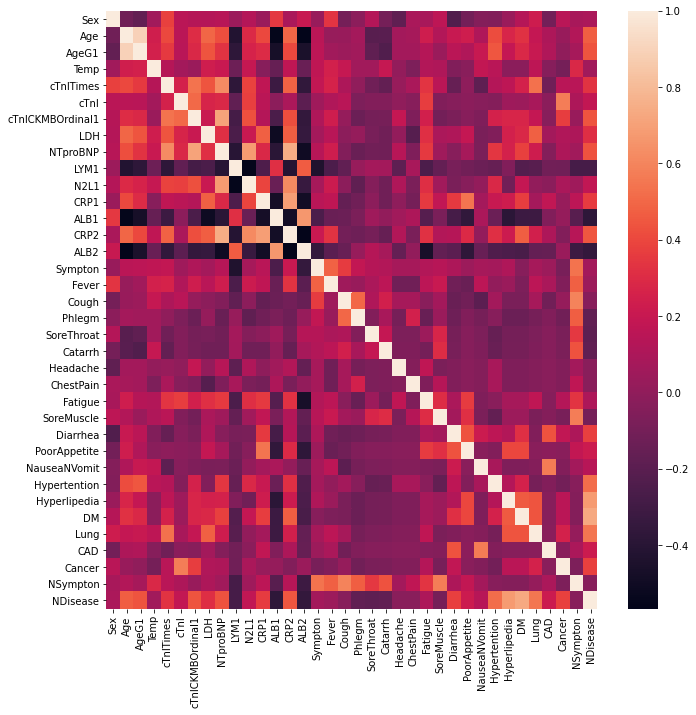

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(11, 11)
sns.heatmap(corrmat)

In [14]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack()
corrmat = corrmat.sort_values(ascending=False)
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat

,feature1,feature2,corr
0,Age,AgeG1,0.893413
1,AgeG1,Age,0.893413


In [40]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

for feature in corrmat.feature1.unique():
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature
        correlated_block = corrmat[corrmat.feature1 == feature]
        grouped_feature_ls = grouped_feature_ls + list(
            correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))

found 9 correlated groups
out of 54 total features


In [41]:
# now we can visualise each group. We see that some groups contain
# only 2 correlated features, some other groups present several features 
# that are correlated among themselves.

for group in correlated_groups:
    print(group)
    print()

  feature1 feature2      corr
0      LDH     HBDH  0.958191

  feature1      feature2      corr
2   Height  PoorAppetite  0.911704

  feature1 feature2      corr
4     WBC2     NEU2  0.911419

  feature1 feature2     corr
6     WBC1     NEU1  0.90352

  feature1 feature2      corr
8      Age    AgeG1  0.893413

            feature1          feature2      corr
10  cTnICKMBOrdinal2  cTnICKMBOrdinal1  0.853741

   feature1 feature2      corr
12     LYM1     LYM2  0.842688

   feature1 feature2      corr
14      BMI   Weight  0.842409

    feature1 feature2      corr
16  NTproBNP     N2L2  0.808767



In [42]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j] >= threshold):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [43]:
corr_features = list((correlation(X_train, 0.8)))
print(corr_features)

['HBDH', 'NEU1', 'AgeG1', 'NEU2', 'BMI', 'N2L2', 'cTnICKMBOrdinal2', 'LYM2']


In [44]:
for i in corr_features:
    if i in categorical_features:
        corr_features.remove(i)

In [45]:
for i in corr_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in corr_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [46]:
corr_features

['HBDH', 'NEU1', 'NEU2', 'BMI', 'N2L2', 'cTnICKMBOrdinal2', 'LYM2']

In [47]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

d:\anaconda3\envs\covid19\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
X_train.shape, X_test.shape

((77, 47), (9, 47))

### 3.3 Statistical Methods

#### 3.3.1 Mutual Information

In [49]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile

In [50]:
mi = mutual_info_classif(X_train, y_train)
mi = pd.Series(mi)
mi.index = X_train.columns

Features on the left side have more mutual information with y

<AxesSubplot:>

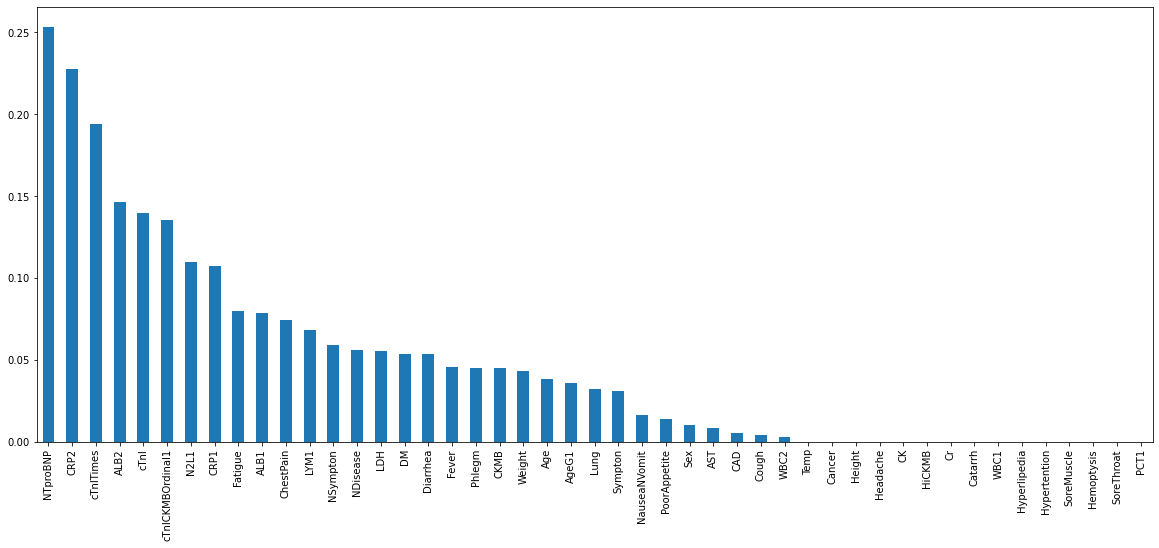

In [51]:
mi.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [52]:
sel_ = SelectKBest(mutual_info_classif, k = 40).fit(X_train, y_train)

In [53]:
mi_features = list(X_train.columns[ ~ sel_.get_support()].values)

In [54]:
for i in mi_features:
    if i in categorical_features:
        mi_features.remove(i)

In [55]:
for i in mi_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in mi_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [56]:
mi_features

['Height', 'Temp', 'CK', 'HiCKMB', 'Cr', 'PCT1']

In [57]:
X_train.drop(labels=mi_features, axis=1, inplace=True)
X_test.drop(labels=mi_features, axis=1, inplace=True)

d:\anaconda3\envs\covid19\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [58]:
X_train.shape, X_test.shape

((77, 41), (9, 41))

#### 3.3.2 Fisher Score

In [59]:
from sklearn.feature_selection import chi2

categorical features

In [60]:
f_score = chi2(X_train[categorical_features], y_train)

The smaller ones have more correlations

In [61]:
p_values = pd.Series(f_score[1])
p_values.index = X_train[categorical_features].columns
p_values.sort_values(ascending=False)

Cancer          0.887949
SoreThroat      0.842057
Cough           0.703238
Headache        0.638344
Hemoptysis      0.594525
ChestPain       0.356552
NauseaNVomit    0.356552
Diarrhea        0.333947
Sex             0.302537
Fever           0.202574
Catarrh         0.159040
Hypertention    0.154388
SoreMuscle      0.105717
Hyperlipedia    0.099153
Lung            0.062605
PoorAppetite    0.060289
Phlegm          0.046410
AgeG1           0.037459
DM              0.008457
Fatigue         0.000049
dtype: float64

In [62]:
p_values[p_values<0.05].index.values

array(['AgeG1', 'Phlegm', 'Fatigue', 'DM'], dtype=object)

In [63]:
# for c in categorical_features:
#     if c not in p_values[p_values<0.05].index.values:
#         categorical_features.remove(c)
#         print(c)
#         X_train.drop(labels=c, axis=1, inplace=True)
#         X_test.drop(labels=c, axis=1, inplace=True)

In [64]:
X_train.shape, X_test.shape

((77, 41), (9, 41))

#### 3.3.3 Univariate

Non-categorical features

In [65]:
from sklearn.feature_selection import f_classif, f_regression

In [66]:
univariate = f_classif(X_train[numerical_features], y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train[numerical_features].columns
univariate.sort_values(ascending=False, inplace=True)

<AxesSubplot:>

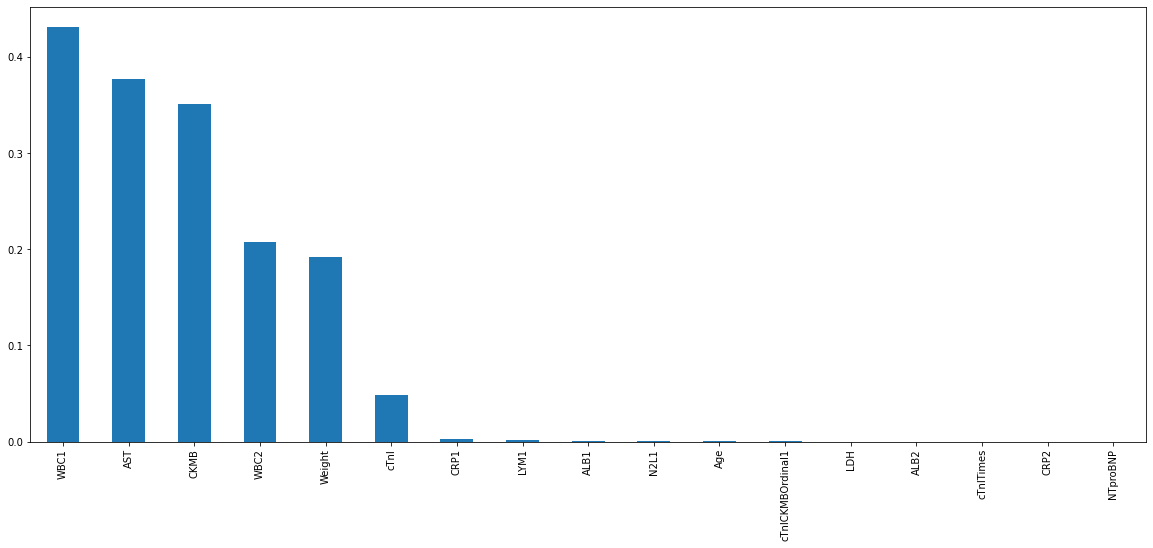

In [67]:
univariate.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [68]:
univariate[univariate > 0.05]

WBC1      0.430778
AST       0.376614
CKMB      0.351257
WBC2      0.207957
Weight    0.191531
dtype: float64

In [ ]:
for n in numerical_features:
    if n in univariate[univariate > 0.05].index.values:
        numerical_features.remove(n)
        print(n)
        X_train.drop(labels=n, axis=1, inplace=True)
        X_test.drop(labels=n, axis=1, inplace=True)

In [70]:
X_train.shape

(77, 36)

#### 3.3.4 ROC-AUC

In [71]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [72]:
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [73]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False)

cTnITimes           0.775
CRP2                0.675
Fever               0.675
NTproBNP            0.650
SoreThroat          0.650
Headache            0.625
LYM1                0.625
ALB2                0.625
N2L1                0.625
NSympton            0.600
AgeG1               0.550
Phlegm              0.500
Hemoptysis          0.500
cTnICKMBOrdinal1    0.500
ChestPain           0.500
Fatigue             0.500
SoreMuscle          0.500
Diarrhea            0.500
PoorAppetite        0.500
NauseaNVomit        0.500
cTnI                0.500
Lung                0.500
CAD                 0.500
Age                 0.500
CRP1                0.500
LDH                 0.500
Sex                 0.450
ALB1                0.450
Hypertention        0.425
Hyperlipedia        0.400
DM                  0.400
Cancer              0.400
Sympton             0.375
Catarrh             0.375
NDisease            0.375
Cough               0.325
dtype: float64

<AxesSubplot:>

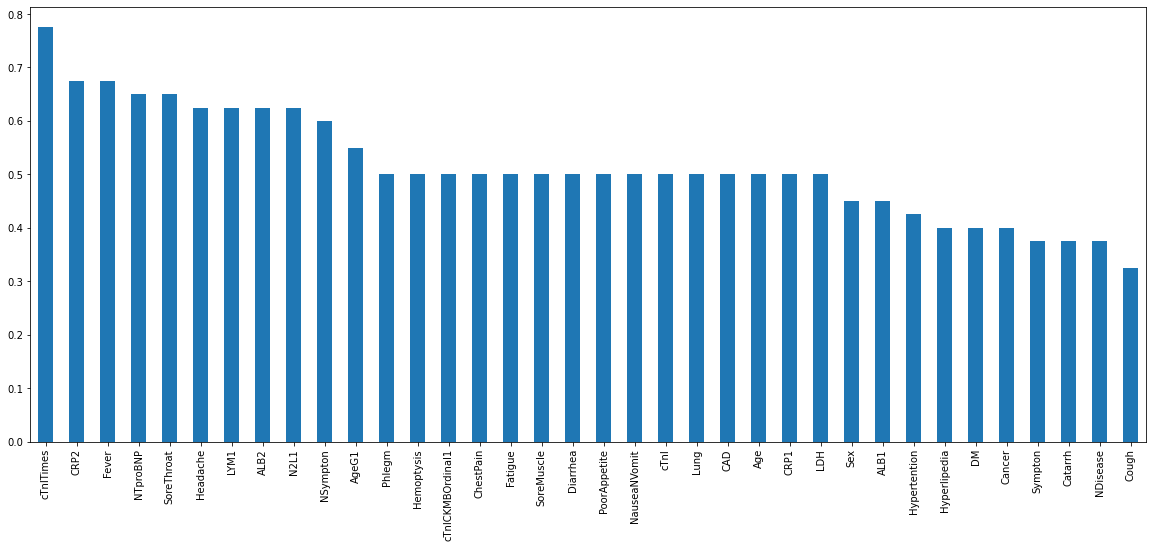

In [74]:
# and now let's plot
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [75]:
# a roc auc value of 0.5 indicates random decision
# let's check how many features show a roc-auc value
# higher than random

len(roc_values[roc_values > 0.5])

11

In [76]:
roc_values[roc_values < 0.5]

Sex             0.450
LDH             0.500
ALB1            0.450
Sympton         0.375
Cough           0.325
Catarrh         0.375
Hypertention    0.425
Hyperlipedia    0.400
DM              0.400
Cancer          0.400
NDisease        0.375
dtype: float64

In [77]:
roc_features = roc_values[roc_values < 0.5].index.values

In [78]:
for i in roc_features:
    if i in numerical_features:
        numerical_features.remove(i)

for i in roc_features:
    if i in categorical_features:
        categorical_features.remove(i)

In [79]:
roc_features

array(['Sex', 'LDH', 'ALB1', 'Sympton', 'Cough', 'Catarrh',
       'Hypertention', 'Hyperlipedia', 'DM', 'Cancer', 'NDisease'],
      dtype=object)

In [80]:
# X_train.drop(labels=roc_features, axis=1, inplace=True)
# X_test.drop(labels=roc_features, axis=1, inplace=True)

In [81]:
X_train.shape, X_test.shape

((77, 36), (9, 36))

## 4. Feature Engineering

### Feature Tools

In [82]:
#collapse-hide
# import featuretools as ft

## 5. Classifier

In [83]:
import sklearn
import sklearn.ensemble
import sklearn.metrics
import xgboost as xgb

**Cross Validation**

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
def cv_score(classifier, X, y, scoring):
    return cross_val_score(classifier, X, y, cv=5, scoring=scoring)

**Decision Tree**

In [86]:
dt = sklearn.tree.DecisionTreeClassifier()

dt_f1 = cv_score(dt, X_train, y_train, 'f1')

dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [87]:
from sklearn import tree

[Text(148.8, 201.90857142857143, 'X[7] <= 1140.0\ngini = 0.344\nsamples = 77\nvalue = [60, 17]'),
 Text(111.60000000000001, 170.84571428571428, 'X[12] <= 14.615\ngini = 0.187\nsamples = 67\nvalue = [60, 7]'),
 Text(74.4, 139.78285714285715, 'gini = 0.0\nsamples = 45\nvalue = [45, 0]'),
 Text(148.8, 139.78285714285715, 'X[7] <= 190.0\ngini = 0.434\nsamples = 22\nvalue = [15, 7]'),
 Text(74.4, 108.72, 'X[4] <= 0.016\ngini = 0.18\nsamples = 10\nvalue = [9, 1]'),
 Text(37.2, 77.65714285714284, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]'),
 Text(111.60000000000001, 77.65714285714284, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(223.20000000000002, 108.72, 'X[13] <= 35.25\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(186.0, 77.65714285714284, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(260.40000000000003, 77.65714285714284, 'X[8] <= 1.48\ngini = 0.444\nsamples = 9\nvalue = [3, 6]'),
 Text(223.20000000000002, 46.59428571428572, 'X[11] <= 39.7\ngini = 0.48\nsamples = 5\nvalue = [

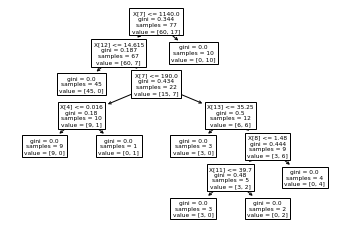

In [88]:
tree.plot_tree(dt)

In [89]:
tree.export_graphviz(dt,
                     out_file="tree.dot",
                     feature_names = X_train.columns, 
                     class_names=['Normal', 'Severe'],
                     filled = True)

**Random Forest**

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=100)

rf_f1 = cv_score(rf, X_train, y_train, 'f1')

rf.fit(X_train, y_train)

RandomForestClassifier()

In [92]:
# we get the feature importance attributed by the 
# random forest model (more on this in coming lectures)

importance = pd.concat(
    [pd.Series(X_train.columns),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']
importance.sort_values(by='importance', ascending=False)

,feature,importance
7,NTproBNP,0.177084
12,CRP2,0.131552
3,cTnITimes,0.094925
10,CRP1,0.087578
13,ALB2,0.071429
4,cTnI,0.067491
6,LDH,0.065550
9,N2L1,0.043029
11,ALB1,0.041507
8,LYM1,0.041117


**XGBoost**

In [93]:
# Create a model
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
xgbc = xgb.XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    objective = 'binary:logistic'
)

xgbc_f1 = cv_score(xgbc, X_train, y_train, 'f1')

# Fit the models
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=4, reg_lambda=1, scale_pos_weight=9, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

**Neural Networks**

In [94]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [95]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

In [5]:
def build_classifier() :
    nn = Sequential()
    nn.add(Dense(activation='relu', input_dim=X_train.shape[1], units=10))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer="uniform", activation='relu', units=15))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer="uniform", activation='relu', units=5))
    nn.add(Dropout(rate = 0.1))
    nn.add(Dense(kernel_initializer='uniform',activation='sigmoid', units=1))
    nn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return nn

In [109]:
nn = KerasClassifier(build_fn=build_classifier, epochs=800, batch_size=50, verbose=0)
# nn = build_classifier();

In [110]:
history = nn.fit(X_train, y_train, batch_size=50, epochs=800, validation_split = 0.2) #verbose = 2

In [111]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


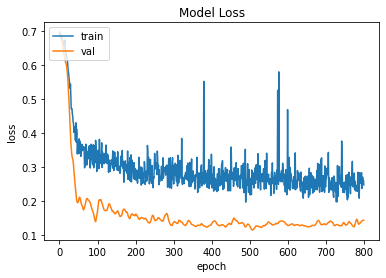

In [112]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'],loc='upper left')
plt.show()

In [113]:
nn_f1 = cv_score(nn, X_train, y_train, 'f1')

## 6. Results

**Cross Validation**

In [ ]:
print("Decision Tree")
# print('Precision', np.mean(dt_precision))
# print('Recall', np.mean(dt_recall))
print('F1', np.mean(dt_f1))

print()

print("Random Forest")
# print('Precision', np.mean(rf_precision))
# print('Recall', np.mean(rf_recall))
print('F1', np.mean(rf_f1))

print()
print("XGBoost")
# print('Precision', np.mean(xgbc_precision))
# print('Recall', np.mean(xgbc_recall))
print('F1', np.mean(xgbc_f1))

print()
print("NN")
# print('Precision', np.mean(xgbc_precision))
# print('Recall', np.mean(xgbc_recall))
print('F1', np.mean(nn_f1))

Save Models

In [2]:
import pickle

In [ ]:
with open("model-3.pkl", 'wb') as f:
    pickle.dump([dt, rf, xgbc], f)
# with open("model-4.pkl", 'wb') as f:
#     pickle.dump([dt, rf, xgbc, nn], f)
with open("dataset.pkl", 'wb') as f:
    pickle.dump([X_train, X_test, y_train, y_test], f)

In [ ]:
nn.model.save('nn.h5')

Load Keras Model

In [ ]:
from keras.models import load_model

In [ ]:
nn = load_model("nn.h5")

Load Models

In [ ]:
with open("model-4.pkl", 'rb') as f:
    [dt, rf, xgbc, nn] = pickle.load(f)

Load Dataset

In [3]:
with open("dataset.pkl", 'rb') as f:
    [X_train, X_test, y_train, y_test] = pickle.load(f)

In [4]:
X_train.shape

(77, 36)

In [5]:
X_test.shape

(9, 36)

**Prediction**

In [14]:
import sklearn

In [15]:
dt_pred = dt.predict(X_test)

rf_pred = rf.predict(X_test)
xgbc_pred = xgbc.predict(X_test)

nn_pred = nn.predict(X_test)
nn_pred[nn_pred > 0.5] = 1
nn_pred[nn_pred <= 0.5] = 0

In [16]:
print("Decision Tree")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, dt_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, dt_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, dt_pred))

print()

print("Random Forest")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, rf_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, rf_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, rf_pred))

print()

print("XGBoost")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, xgbc_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, xgbc_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, xgbc_pred))

print()

print("NN")
print("Precision: ", sklearn.metrics.accuracy_score(y_test, nn_pred))
print("Recal: ", sklearn.metrics.recall_score(y_test, nn_pred))
print("F1: ", sklearn.metrics.f1_score(y_test, nn_pred))

Decision Tree
Precision:  0.6666666666666666
Recal:  0.5
F1:  0.5714285714285715

Random Forest
Precision:  0.5555555555555556
Recal:  0.25
F1:  0.3333333333333333

XGBoost
Precision:  0.7777777777777778
Recal:  1.0
F1:  0.8

NN
Precision:  0.7777777777777778
Recal:  1.0
F1:  0.8


## 7. Explain

### 7.1 Partial Dependence Plot

In [17]:
from sklearn.inspection import plot_partial_dependence

In [18]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'SoreThroat', 'Catarrh',
       'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

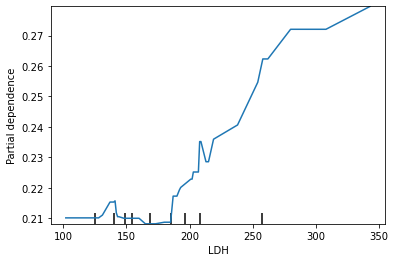

In [19]:
plot_partial_dependence(rf, X_train, [7]) 

In [20]:
nn._estimator_type = 'classifier'

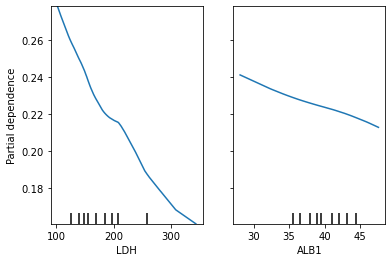

In [21]:
plot_partial_dependence(nn, X_train, [7, 12])
fig = plt.gcf()
fig.subplots_adjust(hspace=0.3)
fig.savefig("nn_pdp_crp_ntproBNP")

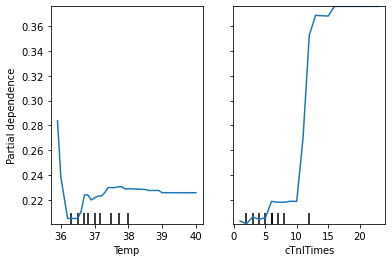

In [22]:
plot_partial_dependence(rf, X_train, [3, 4]) 

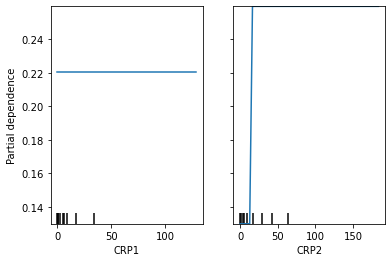

In [23]:
plot_partial_dependence(dt, X_train, [11, 13]) 

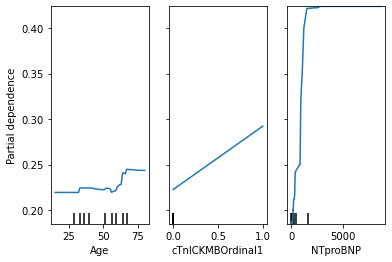

In [24]:
plot_partial_dependence(rf, X_train, [1, 6, 8]) 

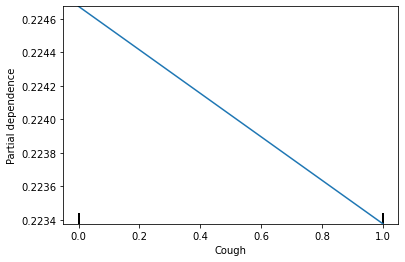

In [25]:
plot_partial_dependence(rf, X_train, [17]) 

In [26]:
def my_pdp(model, X, feat_idx):
    X = np.array(X)
    fmax, fmin = np.max(X[:, feat_idx]), np.min(X[:, feat_idx])
    frange = np.linspace(fmin, fmax, 100)
    preds = []
    for x in frange:
        X_ = X.copy()
        X_[:, feat_idx] = x
        pred = model.predict(X_)
        preds.append(np.mean(pred))
    return (frange, np.array(preds))

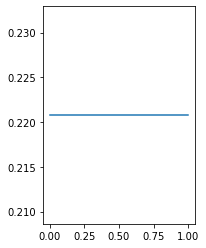

In [27]:
my_data = my_pdp(dt, X_train, 6)
# sk_data = partial_dependence(dtr, X = X_train, features = [6], percentiles=[0,1])

plt.subplot(121)
plt.plot(my_data[0], my_data[1])
# plt.subplot(122)
# plt.plot(sk_data[1][0], sk_data[0][0])
plt.show()

### 7.2 Individual Conditional Expectation (ICE)

In [8]:
def my_ice(model, X, feat_idx):
#     X = np.array(X)
    fmax, fmin = np.max(np.array(X)[:, feat_idx]), np.min(np.array(X)[:, feat_idx])
    frange = np.linspace(fmin, fmax, 100)
    preds = []
    for x in frange:
        X_ = X.copy()
        X_.iloc[:, feat_idx] = x
        pred = model.predict_proba(X_)
#         print(pred.shape)
        preds.append(pred[:, 1])
    return (frange, np.array(preds))

In [52]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'SoreThroat', 'Catarrh',
       'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [72]:
BNP_data = my_ice(nn, X_train, 8)
CRP_data = my_ice(nn, X_train, 13)
# sk_data = partial_dependence(dtr, X = X_train, features = [6], percentiles=[0,1])

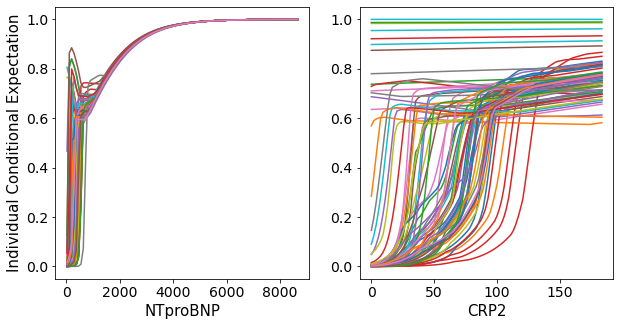

In [73]:
# parameters = {'axes.labelsize': 15,
#           'axes.titlesize': 20}
# plt.rcParams.update(parameters)

f = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(BNP_data[0], BNP_data[1])
plt.xlabel('NTproBNP')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylabel('Individual Conditional Expectation')

plt.subplot(122)
plt.plot(CRP_data[0], CRP_data[1])
plt.xlabel('CRP2')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

f.savefig('nn_ice_crp_ntproBNP.png')

### 7.3 Accumulated Local Effects (ALE) Plot

In [74]:
from alibi.explainers import ALE, plot_ale

In [75]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict_proba(X_data)

In [76]:
def ale_plot(model, feature_names, target_names, X_train, features):
    my_ale = ALE(model.predict_proba, feature_names=feature_names, target_names=target_names)
    exp = my_ale.explain(X_train.to_numpy())
    plot_ale(exp, features=features, fig_kw={'figwidth':10, 'figheight': 5})

In [92]:
def ale_plot_xgbc(model, feature_names, target_names, X_train, features):
    my_ale = ALE(predict_fn_xbg, feature_names=feature_names, target_names=target_names)
    exp = my_ale.explain(X_train.to_numpy())
    plot_ale(exp, features=features, fig_kw={'figwidth':10, 'figheight': 5})

In [93]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'SoreThroat', 'Catarrh',
       'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

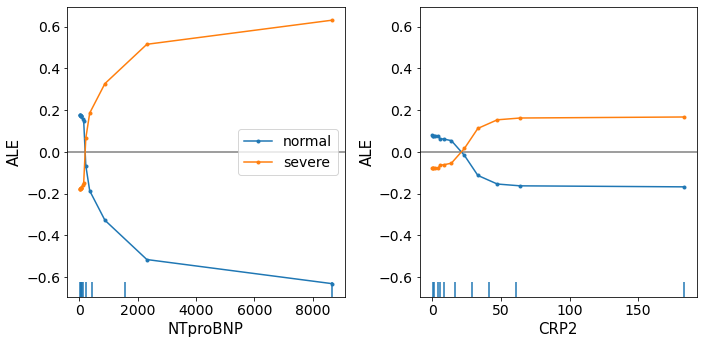

In [101]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})

ale_plot(nn, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

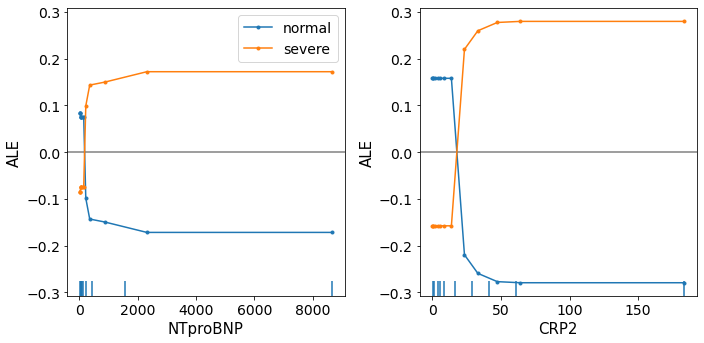

In [98]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 20}
plt.rcParams.update(parameters)
plt.rcParams.update({'font.size': 14})

ale_plot_xgbc(xgbc, X_train.columns, ['normal', 'severe'], X_train, [8, 13])

In [ ]:
plt.figure()

### 7.4 Feature Interaction

H-Statistic

### 7.5 Permutation Feature Importance

In [138]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot

In [139]:
results = permutation_importance(rf, X_train, y_train, scoring='accuracy')

Feature:                 cTnI,	 Score: 0.013 	 Actual: 0.069
Feature:             NTproBNP,	 Score: 0.018 	 Actual: 0.160
Feature:                 LYM1,	 Score: 0.008 	 Actual: 0.042
Feature:                 CRP1,	 Score: 0.010 	 Actual: 0.085
Feature:                 ALB1,	 Score: 0.003 	 Actual: 0.046
Feature:                 CRP2,	 Score: 0.029 	 Actual: 0.125
Feature:                 ALB2,	 Score: 0.008 	 Actual: 0.052
Feature:         Hypertention,	 Score: 0.013 	 Actual: 0.008
Feature:             NDisease,	 Score: 0.010 	 Actual: 0.019


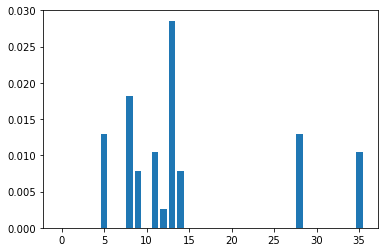

In [140]:
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    if v != 0:
        print('Feature: %20s,\t Score: %.3f \t Actual: %.3f' % (X_train.columns[i],v, rf.feature_importances_[i]))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

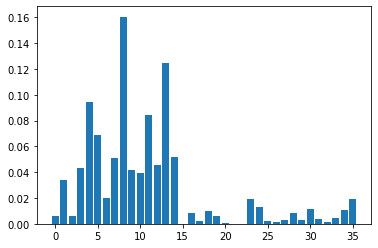

In [141]:
pyplot.bar([x for x in range(len(rf.feature_importances_))], rf.feature_importances_)
pyplot.show()

### 7.6 Global Surrogate

 R-squared measure

In [142]:
y_s = rf.predict_proba(X_test)
y_o = nn.predict_proba(X_test)

In [143]:
1 - ( np.sum(np.power(y_s - y_o, 2)) / np.sum(np.power(y_o - np.mean(y_o), 2)) )

0.758393421249955

### 7.7 LIME

In [53]:
from lime import lime_tabular

In [429]:
X_train.columns

Index(['Sex', 'Age', 'AgeG1', 'Temp', 'cTnITimes', 'cTnI', 'cTnICKMBOrdinal1',
       'LDH', 'NTproBNP', 'LYM1', 'N2L1', 'CRP1', 'ALB1', 'CRP2', 'ALB2',
       'Sympton', 'Fever', 'Cough', 'Phlegm', 'SoreThroat', 'Catarrh',
       'Headache', 'ChestPain', 'Fatigue', 'SoreMuscle', 'Diarrhea',
       'PoorAppetite', 'NauseaNVomit', 'Hypertention', 'Hyperlipedia', 'DM',
       'Lung', 'CAD', 'Cancer', 'NSympton', 'NDisease'],
      dtype='object')

In [510]:
categorical_features = [0, 2, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
categorical_names = {}
for c in categorical_features:
    categorical_names[c] = ["False", "True"]

In [697]:
idx = 7
print('Probability(normal) =', rf.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])

Probability(normal) = 0.52


In [693]:
print("Pred: ", rf_pred.reshape(1, -1)[0])
print("True: ", y_test)

Pred:  [0 0 1 0 1 0 0 0 0]
True:  [0 1 0 0 1 1 0 1 0]


In [587]:
y_test.shape

(9,)

In [554]:
[1, 5, 7]

[0, 5, 7]

Patient id: 5
Probability(normal) = 0.3308184
True class: severe


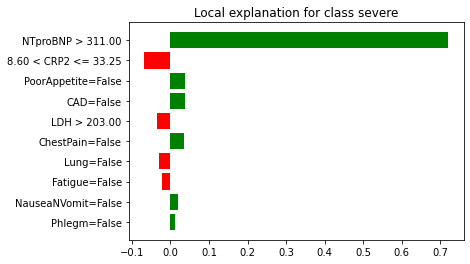

In [602]:
idx = 5
class_names = ['normal', 'severe']

print('Patient id: %d' % idx)
print('Probability(normal) =', nn.predict_proba(np.array(X_test)[idx, :].reshape(1, -1))[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = class_names, 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = nn.predict_proba, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

In [568]:
# exp.save_to_file('./covid19.html')

In [569]:
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
# sc.inverse_transform(X_test[idx])

In [ ]:
exp.as_list()

In [678]:
xgbc.predict_proba(X_test[5:6])

array([[0.26909047, 0.7309095 ]], dtype=float32)

In [674]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict_proba(X_data)

Patient id: 5
Probability(normal) = 0.26909047
True class: severe


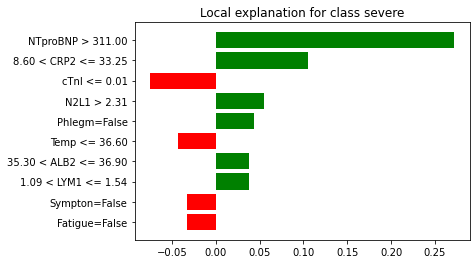

In [676]:
idx = 5
print('Patient id: %d' % idx)
print('Probability(normal) =', xgbc.predict_proba(X_test[idx:idx+1])[0][0])
print('True class: %s' % class_names[y_test[idx]])
explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), 
                                              feature_names= X_train.columns, class_names = ['normal', 'severe'], 
                                              categorical_features = categorical_features, categorical_names = categorical_names,
                                              discretize_continuous=True)
exp = explainer.explain_instance(np.array(X_test)[idx, :], predict_fn = predict_fn_xbg, num_features = 10)

%matplotlib inline
fig = exp.as_pyplot_figure()

#### More Train Cases

In [ ]:
y_pred = xgbc.predict(X_train)
y_predprob = xgbc.predict_proba(X_train)

In [ ]:
for i, j in enumerate(y_predprob):
    if np.abs(j[0] - j[1]) < 0.2 * 2:
        print(j)
        print(i, 'Close', y_train[i])
    if y_pred[i] != y_train[i]:
        print(j)
        print("[", i, "]", "Predict:", y_pred[i], "Truth:", y_train[i])

In [ ]:
exp  = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, 
                                                  categorical_features=categorical_features, categorical_names = categorical_names,
                                                  discretize_continuous=True)

In [ ]:
idx = 27
exp = exp.explain_instance(X_train[idx, :], xgbc.predict_proba, num_features=10)
exp.show_in_notebook()

In [ ]:
for i, f in enumerate(feature_names):
    print(f, X_train[27][i])

#### More test cases

In [ ]:
y_predt = xgbc.predict(X_test)
y_predprobt = xgbc.predict_proba(X_test)

In [ ]:
for i, j in enumerate(y_predprobt):
    if np.abs(j[0] - j[1]) < 0.2 * 2:
        print(j)
        print(i, 'Close', y_test[i])
    if y_predt[i] != y_test[i]:
        print(j)
        print("[", i, "]", "Predict:", y_predt[i], "Truth:", y_test[i])

In [ ]:
exp  = lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names, class_names=class_names, 
                                                  categorical_features=categorical_features, categorical_names = categorical_names,
                                                  discretize_continuous=True)

In [ ]:
idx = 2
exp = exp.explain_instance(X_test[idx, :], xgbc.predict_proba, num_features=10)
exp.show_in_notebook()

In [ ]:
y_predprobt

In [ ]:
y_test

In [ ]:
for i, f in enumerate(feature_names):
    print(f, X_test[2][i])

### 7.8 Scoped Rules (Anchors)

In [ ]:
from alibi.explainers import AnchorTabular
from alibi.utils.data import gen_category_map

In [ ]:
explainer = AnchorTabular(rf.predict, X_train.columns)

In [ ]:
explainer.fit(X_train.to_numpy(), disc_perc=[25, 50, 75])

In [ ]:
idx = 1
print('Prediction: ', explainer.predictor(X_test.to_numpy()[idx].reshape(1, -1))[0])
print(y_test[idx])

In [ ]:
explanation = explainer.explain(X_test.to_numpy()[idx].reshape(1, -1), threshold=0.8)
print('Anchor: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

### 7.9 Shapley Values

Game Theory

### 7.10 SHAP (SHapley Additive exPlanations)

In [698]:
import shap
shap.initjs()

In [699]:
from alibi.explainers import KernelShap

Kernel Shap

In [700]:
def predict_fn_xbg(X):
    X_data = pd.DataFrame(data=X, columns=xgbc.get_booster().feature_names)
    return xgbc.predict(X_data)

In [703]:
explainer = KernelShap(rf.predict_proba)

In [704]:
explainer.fit(X_train)

KernelShap(meta={
    'name': 'KernelShap',
    'type': ['blackbox'],
    'task': 'classification',
    'explanations': ['local', 'global'],
    'params': {
        'groups': None,
        'group_names': None,
        'weights': None,
        'kwargs': {},
        'summarise_background': False
    }
})

In [705]:
explanation = explainer.explain(X_test.to_numpy()[5].reshape(1, -1))

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


In [706]:
shap.force_plot(
    explanation.expected_value[0],
    explanation.shap_values[0][0, :] ,
    X_test.to_numpy()[5].reshape(1, -1),
    X_train.columns,
)

In [717]:
explanation.shap_values[0]

array([[-0.00308013,  0.00255641, -0.00352397,  0.02371188,  0.00339383,
         0.01556609,  0.00225176, -0.0223011 , -0.01894653,  0.00559539,
        -0.00483903, -0.05931478, -0.00148271, -0.02507473,  0.00206165,
         0.00501227,  0.00101676, -0.00072845, -0.00392786,  0.00225693,
         0.        ,  0.        ,  0.        ,  0.0043339 ,  0.00216046,
         0.00110417,  0.        ,  0.        , -0.00400927,  0.        ,
         0.00258468,  0.        ,  0.        ,  0.        ,  0.00291564,
        -0.00552702]])

## Metrics

In [ ]:
from aix360.metrics import faithfulness_metric, monotonicity_metric

In [ ]:
coefs = permutation_importance(rf, X_train, y_train, scoring='accuracy').importances_mean

In [206]:
x = X_test.iloc[0, :]
base = np.zeros(x.shape[0])

In [208]:
print("Faithfulness: ", faithfulness_metric(rf, x.to_numpy(), coefs, base))

Faithfulness:  0.3019123790292113


In [211]:
print("Monotonity: ", monotonicity_metric(rf, x.to_numpy(), coefs, base))

Monotonity:  False
